## Midterm BME 502 2025

In this midterm exam, you are tasked to develop a method to tell whether data is better described by a line fit or a sigmoidal fit.

In [51]:
import Pkg
Pkg.activate(".")

  Activating project at `c:\Users\Alex\Documents\JuliaNotebooks\BME-502-2025-homeworks`


In [52]:
Pkg.add(["Plots","Distributions","Random","Statistics","LsqFit","ForwardDiff"])

   Resolving package versions...
  No Changes to `C:\Users\Alex\Documents\JuliaNotebooks\BME-502-2025-homeworks\Project.toml`
  No Changes to `C:\Users\Alex\Documents\JuliaNotebooks\BME-502-2025-homeworks\Manifest.toml`


In [53]:
using Plots, Distributions, Random, Statistics, LsqFit, ForwardDiff, LinearAlgebra

In [54]:
line_fit(x,p) = p[1] .+ p[2] .* x

line_fit (generic function with 1 method)

In [55]:
sigmoid_fit(x,p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3]*(x .- p[4])))

sigmoid_fit (generic function with 1 method)

Let's create some plots to see how these functions look

In [56]:
x = 0:0.1:10

0.0:0.1:10.0

In [57]:
y_line = line_fit(x,[2,0.5])

2.0:0.05:7.0

In [58]:
y_sigmoid = sigmoid_fit(x,[2.5,3.5,0.1,5.5])

101-element Vector{Float64}:
 3.7805254314621974
 3.788656537923644
 3.796809108114118
 3.8049828179038157
 3.8131773393604975
 3.8213923407935093
 3.8296274867991844
 3.837882438307629
 3.8461568526308625
 3.854450383512326
 ⋮
 4.57010642451473
 4.5785558602695
 4.586989447538757
 4.595406810393582
 4.603807575969294
 4.612191374526542
 4.620557839511163
 4.6289066076128
 4.637237318822277

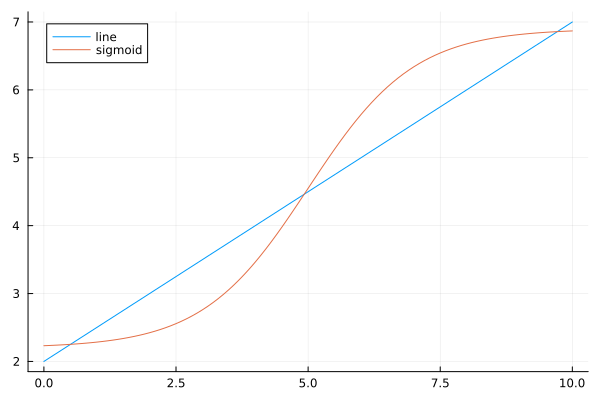

In [59]:
y_line = line_fit(x,[2,0.5])
y_sigmoid = sigmoid_fit(x,[2.2,4.7,1,5.0])
plot(x, y_line, label = "line")
plot!(x, y_sigmoid, label = "sigmoid")

Let us add some serious noise to it

In [60]:
nd = Normal(0,5)
x_line = 10*rand(200)
y_line_n = line_fit(x_line,[2,0.5]) .+ rand(nd,length(x_line))
x_sigmoid = 10*rand(200)
y_sigmoid_n = sigmoid_fit(x_sigmoid,[2.2,4.7,1,5.0]) .+ rand(nd,length(x_sigmoid))

200-element Vector{Float64}:
  8.210635242594762
  4.095700735909259
 11.566096072290252
  4.99371436815686
  8.115043057288517
  4.947641538343498
  3.7434561609806236
  1.0922885881807005
  3.594802477752692
  5.514488924866754
  ⋮
 -1.679182003945633
  8.922157738407902
 10.751029833689321
  4.280180888523558
 -0.43142930838826077
  4.294586851419153
 13.6907383575485
  1.5316546112771565
  6.789604893029659

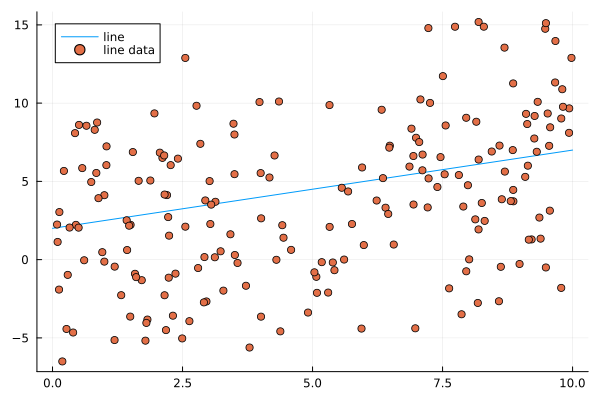

In [61]:
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")

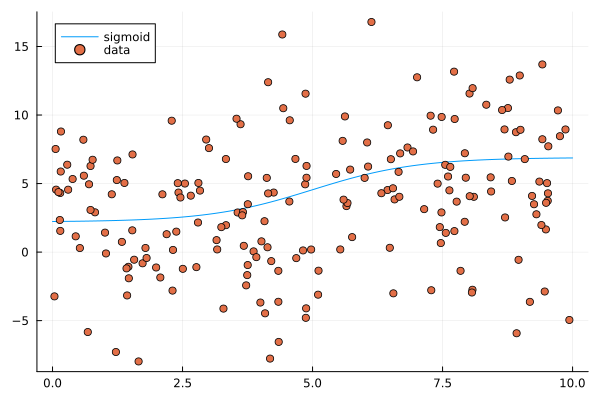

In [62]:
plot(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "data")

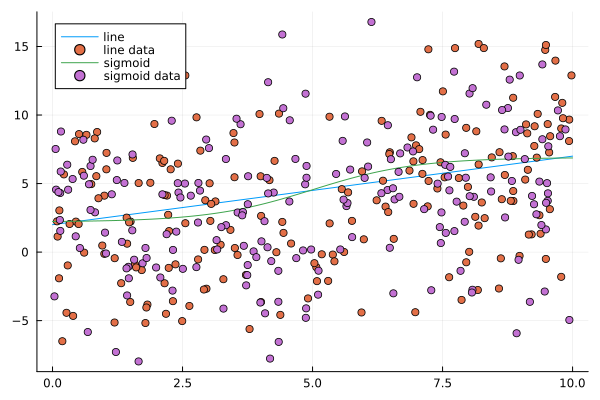

In [63]:
# let's plot it all together
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")
plot!(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "sigmoid data")

# Question:

If you take the sigmoid data, which fit is better? The linear or sigmoid?

How uncertain are the parameters?

At what noise level are the two fits equally likely?

# Part 1 (20 points)
Create a function line_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix.  The standard deviation of the measurement error, sigma, can be supplied as a number (assuming that all measurements share the same error) or as a vector with the same length as y. If sigma (standard deviation of measurement error) is not specified (sigma=[]), estimate the measurement error using the sum of least squares to estimate $\mathcal{X}^2$.

In [64]:
res(fitfct,β,(x,y)) = fitfct(x,β) .- y 

function lsqfitting(fitfct, (x,y), β0) 
    fit = curve_fit(fitfct, x, y, β0)
    lq(β) = sum(abs2, (fitfct(x,β) .- y))
    σ = sqrt(lq(fit.param)/(length(x)-length(β0)))
    chi2(β) = sum(abs2, (fitfct(x,β) .- y) ./ σ)
    return fit.param, inv(2*ForwardDiff.hessian(chi2,fit.param)), chi2(fit.param)
end

function lsqfitting(fitfct, (x,y) , σ, β0) 
    fit =  curve_fit(fitfct, x, y, 1 ./ σ, β0)
    chi2(β) = sum(abs2, (fitfct(x,β) .- y) ./ σ)
    return fit.param, inv(2*ForwardDiff.hessian(chi2,fit.param)), chi2(fit.param)
end

function curve_fitting(fitfct,num_params,x,y,σ,returnchi2) #returns best parameters, covariance matrix
    initial_guess = repeat([0.0],num_params)
    # fit = lsqfitting(fitfct, (x,y), initial_guess) 
    # β = fit.param
    # chi2val = 0
    if σ == []
        β, cov, chi2best = lsqfitting(fitfct, (x,y), initial_guess)
        # covar_mat = estimate_covar(fit)
        # chisq1(β) = sum(abs2,(res(line_fit,β,(x,y))) ./ line_fit(x,β))
        # chi2val = chisq1(β)
    elseif σ isa Number
        σ_list = repeat([σ],length(x))
        β, cov, chi2best = lsqfitting(fitfct, (x,y), σ_list, initial_guess)
    else #should work for either scalar or vector
        # chisq2(β) = sum(abs2,(fitfct(x,β) .- y) ./ σ)
        # covar_mat = inv(2*ForwardDiff.hessian(chisq2,fit.param))
        # chi2val = chisq2(β)
        β, cov, chi2best = lsqfitting(fitfct, (x,y), σ, initial_guess)
    end
    # cov = sqrt.(covar_mat[diagind(covar_mat)]) #Note: it's the square root of the diagonals that gives the stdev
    if returnchi2
        return β,cov,chi2best
    else
        return β,cov
    end
end

curve_fitting (generic function with 1 method)

In [65]:
line_fitting(x,y;σ=[],returnchi2=false) = curve_fitting(line_fit,2,x,y,σ,returnchi2)

line_fitting (generic function with 1 method)

In [66]:
line_fitting(x_line,y_line_n,σ=4,returnchi2=true)

([0.7180447773325604, 0.599537933373282], [0.07137843673777057 -0.010170465685385054; -0.010170465685385054 0.0020132642957887575], 258.6006204331833)

In [67]:
line_fitting(x_line,y_line_n) 

([0.7180447773325604, 0.599537933373282], [0.09322478800978878 -0.013283276446136229; -0.01328327644613623 0.0026294514948835756])

# Part 2 (20 points)
Similarily, create a function sigmoid_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix. Treat sigma the same way as in Part 1.

In [68]:
sigmoid_fitting(x,y;σ=[],returnchi2=false) = curve_fitting(sigmoid_fit,4,x,y,σ,returnchi2)

sigmoid_fitting (generic function with 1 method)

In [69]:
sigmoid_fitting(x_sigmoid, y_sigmoid_n) 

([2.3135263500957834, 2.991711560754069, 15.537642014859578, 5.441169023617306], [0.04669791266539702 -0.04626790992827799 -0.05360578928026046 0.0024308810537370315; -0.046267909928278 0.10836384144132702 -0.620306883691058 0.008117394183237755; -0.053605789280260496 -0.6203068836910584 243.37214224153803 -0.5281763330818201; 0.0024308810537370315 0.008117394183237757 -0.5281763330818194 0.03294275244705682])

In [70]:
sigmoid_fitting(x_sigmoid, y_sigmoid_n,σ=3) #if the data is too weird, I get errors here

([2.313526446143267, 2.9917114252366335, 15.5376324668803, 5.441168973272496], [0.020490304304366033 -0.020301626394118692 -0.023521378777155155 0.0010666305285996407; -0.020301626394118692 0.047548336546690474 -0.2721802739263568 0.0035617826103574845; -0.023521378777155044 -0.2721802739263567 106.7875333827324 -0.23175524013236348; 0.0010666305285996405 0.0035617826103574854 -0.23175524013236426 0.014454748287253407])

# Part 3 (30 points)
Create a function p_ratio_sig_line(x,y; sigma=[]) that returns the Posterior ratio between a fit to a sigmoid and to a line.  Treat sigma the same way as in Part 1-2.

In [ ]:
function p_ratio_sig_line(x,y;σ=[]) 
    # p_sig(x,y,sigma)/p_line(x,y,sigma)
    linbeta, lincov, linchi2best = line_fitting(x,y,σ=σ,returnchi2=true)
    sigbeta, sigcov, sigchi2best = sigmoid_fitting(x,y,σ=σ,returnchi2=true)
    lin_params=2
    sig_params=4
    # print(det(lincov))
    # print("\n")
    # print(det(sigcov)) 

    pr = exp(-(linchi2best-sigchi2best)/2)*sqrt(det(lincov)/det(sigcov))*sqrt(2*π)^(lin_params-sig_params) #the 0.5 should already be present in the covariant matrix 
    #This clearly needs the "Ockham factor" but I'm not sure how to add it; should I just put in some priors? 
    return pr

    
end

p_ratio_sig_line (generic function with 1 method)

In [97]:
p_ratio_sig_line(x_line,y_line_n,σ=5)

0.0006376323247493062

In [98]:
p_ratio_sig_line(x_sigmoid,y_sigmoid_n,σ=0.9)

2.037963206507864e-43

In [99]:
p_ratio_sig_line(x_sigmoid,y_sigmoid_n)

0.0036071939126988122

In [100]:
function pr_range(sigs)
    try 
        val = p_ratio_sig_line(x_sigmoid,y_sigmoid_n,σ=sigs)
        return val
    catch e 
        return 0 
    end
end
sigs = 0:0.1:100
prs = pr_range.(sigs)

1001-element Vector{Real}:
 0
 0.0
 0.0
 0.0
 1.2295737179410699e-213
 3.7582353532537686e-137
 1.1733794011587621e-95
 1.124291049649435e-70
 1.7207303387449457e-54
 2.037963206507864e-43
 ⋮
 1.9712706614063045e-5
 1.967334839847516e-5
 1.9634135538088784e-5
 1.9594978390443284e-5
 1.955598292690955e-5
 1.9517045437501702e-5
 1.9478317841648517e-5
 1.9439643176425223e-5
 1.9401034736412636e-5

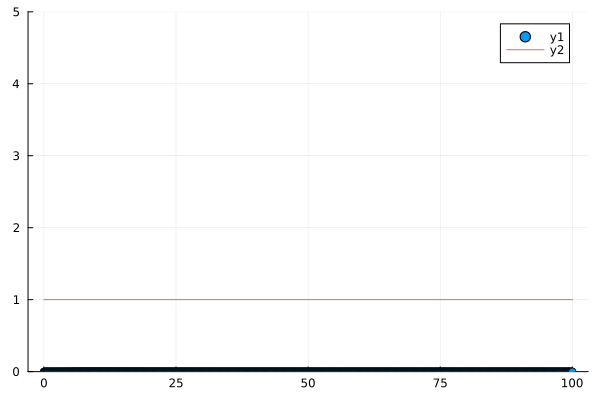

In [101]:
prs[prs .> 1000] .= 0
scatter(sigs,prs,ylims = (0,5))
plot!(sigs, repeat([1],length(sigs)))

# Part 4 (30 points)
Create a function sig_p_ratio_is_one(x,y; sigma=[]) that returns the measurement error (either as a number or array depending on how the sigma is supplied) that would result in a posterior ratio between sigmoid and line of one. If sigma is not provided (sigma=[]), proceed as in Part 1-3.

In [ ]:
function sig_p_ratio_is_one(x,y;sigma=[])
    err_range = 0:1:10
    # test p_ratio on this error range 
    # if any of vals are w/in some range of 1 (abs(arr-1) < 0.01), min if multiple, return the corresponding err 
    # if some are above and some below, set err range to zoom in on that
    # if all are above/below, +10 to the whole range, try again?

    return meas_err
end

## Programming Advice:
To make your program more efficient you should think about creating functions that provide information that you can use for all of the parts.  Don't write each function individually, but think what are the common task that need to be done, and then call these more general functions, to get you the result for the specific questions.  I will reward good programming style with a bonus 10 points total.